In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
import sys
sys.path.append("/Users/bl/Dropbox/software/bpz-1.99.3")
from bpz_tools import *
from scipy.optimize import curve_fit

0.0974584994022 0.0974584994022 0.0319936905994 0.0324861664674
0.111101168937 0.111101168937 0.0368146059882 0.0370337225634
0.10629759285 0.10629759285 0.0352263266703 0.0354325295665
0.0859196755047 0.0859196755047 0.0284756511831 0.0286397351272
0.0332601041863 0.0332601041863 0.0110766406201 0.0110867011836


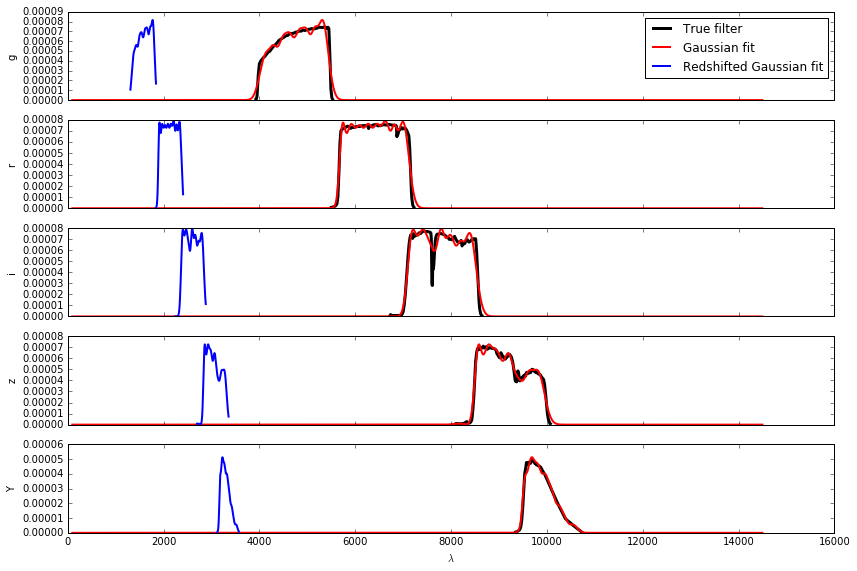

In [2]:
prefix = 'DES'
ab_filters = ['g', 'r', 'i', 'z', 'Y']
tabulatedfilter = [np.genfromtxt('../data/'+prefix+'_FILTERS/'+band+'.res') for band in ab_filters]
numCoefs = 10
numBands = len(ab_filters)
max_redshift = 2.0

fig, axs = plt.subplots(5, 1, figsize=(12, 8), sharex=True)
axs = axs.ravel()
mu_arr = np.zeros((len(ab_filters), numCoefs))
sig_arr = np.zeros((len(ab_filters), numCoefs))
amp_arr = np.zeros((len(ab_filters), numCoefs))
lambdaMinMax_arr = np.zeros((len(ab_filters), 2))
for i, (band, data) in enumerate(zip(ab_filters, tabulatedfilter)):
    x, y = data[:,0], data[:,1]
    y /= x
    ind = np.where(y > 0.01*np.max(y))[0]
    lambdaMin, lambdaMax = x[ind[0]], x[ind[-1]]
    lambdaMinMax_arr[i,:] = lambdaMin, lambdaMax
    sig0 = np.repeat((lambdaMax-lambdaMin)/numCoefs/4, numCoefs)
    mus = np.linspace(lambdaMin+sig0[0], lambdaMax-sig0[-1], num=numCoefs)
    amp0 = interp1d(x, y)(mus)
    p0 = np.concatenate((amp0, sig0))
    def func(p, x, muarr):
        y = 0*x
        n = p.size/2
        for i in range(n):
            y += np.abs(p[i]) * np.exp(-0.5*((muarr[i]-x)/np.abs(p[n+i]))**2.0)
        return y
    def gaussian(x, amparr, muarr, sigarr):
        y = 0*x
        n = amparr.size
        for i in range(n):
            y += np.abs(amparr[i]) * np.exp(-0.5*((muarr[i]-x)/np.abs(sigarr[i]))**2.0)
        return y
    def dfunc(p, x, yd):
        y = 0*x
        n = p.size/2
        for i in range(n):
            y += np.abs(p[i]) * np.exp(-0.5*((mus[i]-x)/np.abs(p[n+i]))**2.0)
        return yd - y
    popt, pcov = scipy.optimize.leastsq(dfunc, p0, args=(x, y))
    amps = np.abs(popt[0:numCoefs])
    sigs = np.abs(popt[numCoefs:2*numCoefs])
    mu_arr[i,:] = mus
    amp_arr[i,:] = amps
    sig_arr[i,:] = sigs
    axs[i].plot(x[ind], y[ind], lw=3, label='True filter', c='k')
    #axs[i].errorbar(mus, amps, xerr=sigs, color='g')
    yy = func(popt, x, mus)
    axs[i].plot(x, yy, lw=2, c='r', label='Gaussian fit')
    
    popt_redshifted = 1*popt
    popt_redshifted[numCoefs:2*numCoefs] /= (1. + max_redshift) 
    mus_redshifted = 1*mus / (1. + max_redshift) 
    lambdaMin_redshifted, lambdaMax_redshifted = lambdaMin / (1. + max_redshift) , lambdaMax / (1. + max_redshift) 
    xf = np.linspace(lambdaMin_redshifted, lambdaMax_redshifted, num=1000)
    yf = func(popt_redshifted, xf, mus_redshifted)
    axs[i].plot(xf, yf, lw=2, c='b', label='Redshifted Gaussian fit')
    axs[i].set_ylabel(band)
    axs[-1].set_xlabel('$\lambda$')
    norm = np.sum([amp*np.sqrt(2*np.pi)*sig for amp, sig in zip(amps,sigs)])
    norm_redshifted = np.sum([amp*np.sqrt(2*np.pi)*sig for amp, sig in zip(amps, popt_redshifted[numCoefs:2*numCoefs])])
    print norm, scipy.integrate.simps(yy, x), scipy.integrate.simps(yf, xf), norm_redshifted
axs[0].legend(loc='upper right')
fig.tight_layout()

np.savetxt('data/'+prefix+'_filter_gaussian_coefficients_amp_'+''.join(ab_filters)+'.txt', amp_arr)
np.savetxt('data/'+prefix+'_filter_gaussian_coefficients_mu_'+''.join(ab_filters)+'.txt', mu_arr)
np.savetxt('data/'+prefix+'_filter_gaussian_coefficients_sig_'+''.join(ab_filters)+'.txt', sig_arr)

[  1000.        1063.41401   1130.84935   1202.56104   1278.82025
   1359.91537   1446.15305   1537.85941   1635.38124   1739.08732
   1849.36982   1966.64577   2091.35866   2223.98009   2365.01158
   2514.98644   2674.47181   2844.07079   3024.42471   3216.2156
   3420.16872   3637.05533   3867.69558   4112.96165   4373.78103
   4651.14002   4946.08744   5259.73867   5593.27977   5947.97206
   6325.1568    6726.26034   7152.79946   7606.38714   8088.73863
   8601.67796   9147.14483   9727.20194  10344.04279  11000.     ]
[-0.00178 -0.00035]
[-0.00133 -0.00028]
[-0.00083 -0.0002 ]
[-0.00055 -0.00018]
[-0.00055 -0.00014]
[-0.00032 -0.0001 ]
[ -1.01957e-04   3.63487e-05]
[ 0.00019  0.00023]
p0 [ 1.       1.       1.       1.       0.14286  0.28571  0.42857  0.57143
  0.71429  0.85714]
-0.00177522929007 0.000186441821799
-0.000354784639976 0.000227322055552
params [ 0.5653   9.57259  4.30089  0.46153]
ts [ 0.       0.14286  0.28571  0.42857  0.57143  0.71429  0.85714  1.     ]
offset 347 

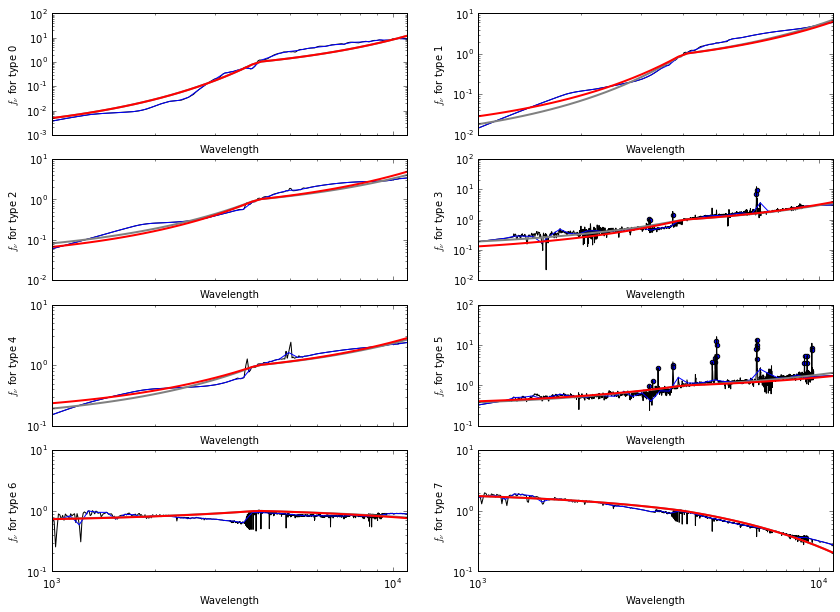

In [255]:
template_names = ['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 
                  'SB3_B2004a', 'Im_B2004a', 'SB2_B2004a', 
                  'ssp_25Myr_z008', 'ssp_5Myr_z008']
sed_interp = []
lambdaMinAbs, lambdaMaxAbs = 1e3, 1.1e4
lambdaRef = 4.0e3
wavelengths = np.linspace(lambdaMinAbs, lambdaMaxAbs, num=20)
wavelengths = np.logspace(np.log10(lambdaMinAbs), np.log10(lambdaMaxAbs), num=40)
print wavelengths
np.set_printoptions(precision=5)

X = np.zeros((16000, 2))
Y = np.zeros((X.shape[0], ))
X_nolines = np.zeros((wavelengths.size*len(template_names), 2))
Y_nolines = np.zeros((X_nolines.shape[0], ))

fig, axs = plt.subplots(4, 2, figsize=(14, 10), sharex=True, sharey=False)
axs = axs.ravel()
off = 0
lines_mu = []
refs = []
alphas = np.zeros((len(template_names), ))
betas = np.zeros((len(template_names), ))
for it, template_name in enumerate(template_names):
    axs[it].set_xlim([lambdaMinAbs, lambdaMaxAbs])
    data = np.genfromtxt('/Users/bl/Dropbox/software/bpz-1.99.3/SED/'+template_name+'.sed')
    data[:,1] *= data[:,0]**2 / 3e18
    ind = np.logical_and(data[:,0] >= lambdaMinAbs, data[:,0] <= lambdaMaxAbs)
    ref = np.interp(lambdaRef, data[ind,0], data[ind,1])
    data[:,1] /= ref
    refs += [ref]
    axs[it].plot(data[ind,0], data[ind,1], 'k')
    theint = np.interp(wavelengths, data[ind,0], data[ind,1] )
    axs[it].set_xlabel('Wavelength')
    axs[it].set_ylabel(r'$f_{\nu}$ for type '+str(it))
    sed_interp.append(scipy.interpolate.interp1d(wavelengths, theint))
    sel = np.where(ind)[0][::2]
    axs[it].plot(wavelengths, theint, 'b')
    
    tn = wavelengths.size
    X_nolines[tn*it:tn*(it+1),0] = it
    X_nolines[tn*it:tn*(it+1),1] = wavelengths
    Y_nolines[tn*it:tn*(it+1)] = theint
    X[off:off+tn,0] = it
    X[off:off+tn,1] = wavelengths
    Y[off:off+tn] = theint
    off += tn
    
    def func(x, a, b):
        v1 = np.exp(-a*(x - lambdaRef))
        v2 = np.exp(-b*(x - lambdaRef))
        return np.concatenate((v1[x<=lambdaRef], v2[x>lambdaRef])) 
        #return np.concatenate(((x[x<=lambdaRef]/lambdaRef)**a, (x[x>lambdaRef]/lambdaRef)**b))
    popt, pcov = curve_fit(func, wavelengths, theint, p0=[1e-4, 1e-4])
    print popt
    alphas[it], betas[it] = popt
    axs[it].plot(wavelengths, func(wavelengths, *popt), 'gray', lw=2)

    diff = (data[sel,1] - sed_interp[it](data[sel,0]) )
    locs = np.argsort(diff)[::-1][0:]
    locs = locs[(1 - sed_interp[it](data[sel[locs],0])/data[sel[locs],1]) > 0.5]
    #print sel[locs].size#, lines_mu
    lines_mu.extend(data[sel[locs],0])
    axs[it].scatter(data[sel[locs],0], data[sel[locs],1])
    tn = sel[locs].size
    if tn > 0:
        X[off:off+tn,0] = it
        X[off:off+tn,1] = data[sel[locs],0]
        Y[off:off+tn] = data[sel[locs],1]
        off += tn
    axs[it].set_xscale('log')
    axs[it].set_yscale('log')
    
        
def func(x, a, b, c, d, t2, t3, t4, t5, t6, t7):
    tn = x.size
    t1 = 0
    t8 = 1
    ts = np.array([t1, t2, t3, t4, t5, t6, t7, t8])
    ts = np.linspace(0, 1, num=len(template_names))
    y = np.zeros((tn*len(template_names), ))
    for it, template_name in enumerate(template_names):
        alpha = alphas[0]*(1-ts[it]**a) + alphas[-1]*ts[it]**b
        beta = betas[0]*(1-ts[it]**c) + betas[-1]*ts[it]**d
        v1 = np.exp(-alpha*(wavelengths - lambdaRef))
        v2 = np.exp(-beta*(wavelengths - lambdaRef))
        y[tn*it:tn*(it+1)] = np.concatenate((v1[x<=lambdaRef], v2[x>lambdaRef])) 
        #y[tn*it:tn*(it+1)] = np.concatenate(((x[x<=lambdaRef]/lambdaRef)**alpha, (x[x>lambdaRef]/lambdaRef)**beta))
        #y[tn*it:tn*(it+1)] = np.exp(-beta*(wavelengths - lambdaRef)) * (wavelengths/lambdaRef)**alpha
    return y

p0 = np.repeat(1., 10)
#p0[0] = alphas[0]
#p0[1] = alphas[-1]
#p0[2] = betas[0]
#p0[3] = betas[-1]
p0[4:] = np.linspace(0, 1, num=len(template_names))[1:-1]
print 'p0', p0
popt, pcov = curve_fit(func, wavelengths, Y_nolines, p0=p0, bounds=[0, 10])

tn = wavelengths.size
y = func(wavelengths, *popt)
for it, template_name in enumerate(template_names):
    axs[it].plot(wavelengths, y[tn*it:tn*(it+1)], 'r', lw=2)

print alphas[0], alphas[-1]
print betas[0], betas[-1]
print 'params', popt[:4]
ts = np.concatenate([np.array([0]), popt[4:], np.array([1])])
print 'ts', ts

X = X[:off,:]
Y = Y[:off]
print 'offset', off, X.shape, Y.shape
#fig.savefig('CWW_templates.pdf')
lines_mu = np.array(lines_mu)
lines_sig = 0*lines_mu + 10.0 
ii = lines_mu.argsort()
#print lines_mu.shape
print lines_mu[ii]

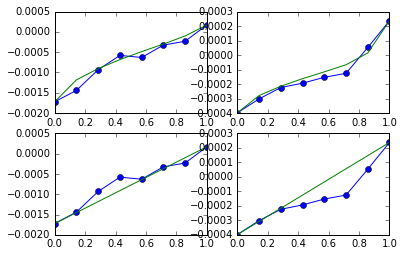

In [254]:
tsi = np.linspace(0, 1, num=len(template_names))
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(ts, alphas, "-o")
#axs[0,0].plot(ts, popt[0]*(1-ts)**3 + popt[1]*ts**3)
axs[0,0].plot(ts, alphas[0]*(1-ts**popt[0]) + alphas[-1]*ts**popt[1])
axs[1,0].plot(tsi, alphas, "-o")
axs[1,0].plot(tsi, alphas[0]*(1-tsi**p0[0]) + alphas[-1]*tsi**p0[1])
axs[0,1].plot(ts, betas, "-o")
#axs[0,1].plot(ts, popt[2]*(1-ts)**0.33 + popt[3]*ts**0.33)
axs[0,1].plot(ts, betas[0]*(1-ts**popt[2]) + betas[-1]*ts**popt[3])
axs[1,1].plot(tsi, betas, "-o")
axs[1,1].plot(tsi, betas[0]*(1-tsi**p0[2]) + betas[-1]*tsi**p0[3])

In [249]:
ts

array([ 0.     ,  0.14286,  0.28571,  0.42857,  0.57143,  0.71429,
        0.85714,  1.     ])

/Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: overflow encountered in exp


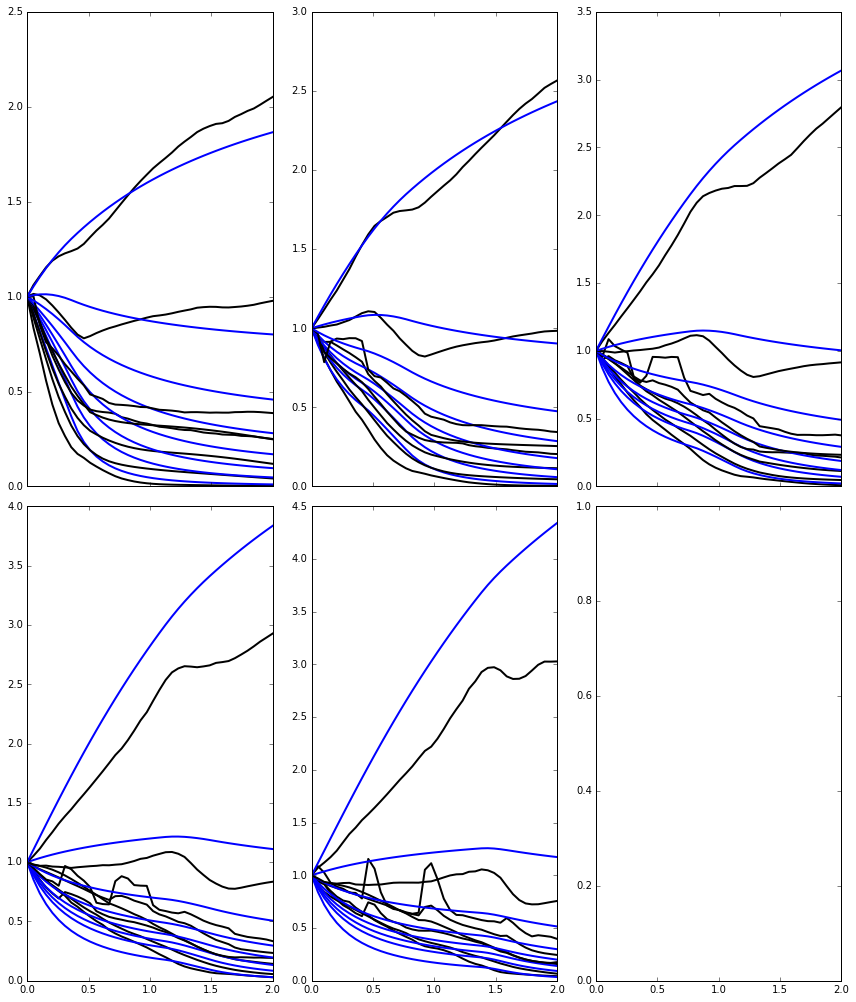

In [248]:
redshiftGrid = np.linspace(0, max_redshift, num=40)
    
nt = len(template_names)
nf = len(ab_filters)
nz = redshiftGrid.size
f_mod = np.zeros((nz, nt, nf))*0.
f_mod2 = np.zeros((nz, nt, nf))*0.
f_mod3 = np.zeros((nz, nt, nf))*0.
f_mod_interps = np.zeros((nt, nf), dtype=object)
f_mod_interps2 = np.zeros((nt, nf), dtype=object)
f_mod_interps3 = np.zeros((nt, nf), dtype=object)
abfiles = []
norms = np.sqrt(2*np.pi) * np.sum(amp_arr * sig_arr, axis=1)
for iz in range(nz):
    oneplusz = (redshiftGrid[iz] + 1)
    for jf in range(nf):
        lambdaMin, lambdaMax = lambdaMinMax_arr[jf,:]
        xf = np.linspace(lambdaMin/oneplusz, lambdaMax/oneplusz, num=10000)
        yf = gaussian(xf, amp_arr[jf,:], mu_arr[jf,:]/oneplusz, sig_arr[jf,:]/oneplusz)
        norm = np.trapz(yf, x=xf)
        for it in range(nt):
            ysed = sed_interp[it](xf)
            f_mod2[iz,it,jf] = np.trapz(ysed*yf, x=xf) / norms[jf] * oneplusz
            alpha = popt[0]*(popt[2+it] - popt[1])
            ysed = np.exp(-alpha*(xf - lambdaRef))
            alpha = alphas[0]*(1-ts[it]**popt[0]) + alphas[-1]*ts[it]**popt[1]
            beta = betas[0]*(1-ts[it]**popt[2]) + betas[-1]*ts[it]**popt[3]
            v1 = np.exp(-alpha*(xf - lambdaRef))
            v2 = np.exp(-beta*(xf - lambdaRef))
            ysed = np.concatenate((v1[xf<=lambdaRef], v2[xf>lambdaRef])) 
            f_mod3[iz,it,jf] = np.trapz(ysed*yf, x=xf) / norms[jf] * oneplusz
            
for it in range(nt):         
    for jf in range(nf):                            
        f_mod[:,it,jf] = lf_z_sed(template_names[it], 
                                  ab_filters[jf]+'_'+prefix, 
                                  z=redshiftGrid, ccd='yes', 
                                  units='nu', madau='no') / refs[it] / (1+redshiftGrid)**2

np.save('./data/CWW_redshiftgrid_zmax'+str(max_redshift)+'_'+prefix+'_'+''.join(ab_filters)+'.npy', f_mod)
np.save('./data/CWW_redshiftgrid_zmax'+str(max_redshift)+'_'+prefix+'_'+''.join(ab_filters)+'_nolines.npy', f_mod2)

for jf in range(nf):                            
    for it in range(nt):
        f_mod_interps[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod[:,it,jf], kind='cubic')
        f_mod_interps2[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod2[:,it,jf], kind='cubic')
        f_mod_interps3[it, jf] = scipy.interpolate.interp1d(redshiftGrid, f_mod3[:,it,jf], kind='cubic')
     
fig, axs = plt.subplots(2, 3, figsize=(12, 14), sharex=True, sharey=False)
axs = axs.ravel()
for ib in range(nf):                            
    for t in range(nt):
        axs[ib].plot(redshiftGrid, f_mod[:,t,ib]/f_mod[0,t,ib], ls='solid', lw=2, c='k')
        #axs[ib].plot(redshiftGrid, f_mod2[:,t,ib]/f_mod2[0,t,ib], ls='solid', lw=2, c='r')
        axs[ib].plot(redshiftGrid, f_mod3[:,t,ib]/f_mod3[0,t,ib], ls='solid', lw=2, c='b')
            
fig.tight_layout()

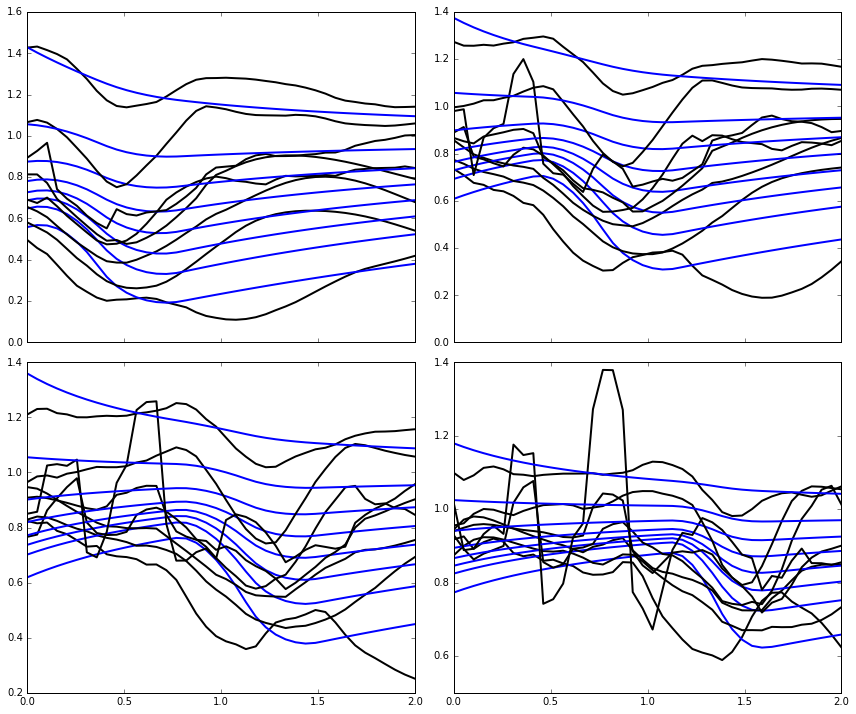

In [245]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=False)
axs = axs.ravel()
for ib in range(nf-1):                            
    for t in range(nt):
        axs[ib].plot(redshiftGrid, f_mod[:,t,ib]/f_mod[:,t,ib+1], ls='solid', lw=2, c='k')
        #axs[ib].plot(redshiftGrid, f_mod2[:,t,ib]/f_mod2[:,t,ib+1], ls='solid', lw=2, c='r')
        axs[ib].plot(redshiftGrid, f_mod3[:,t,ib]/f_mod3[:,t,ib+1], ls='solid', lw=2, c='b')
            
fig.tight_layout()

In [57]:
lines_mu = np.array([ 3732.22, 5002.26, 1392.07, 1542.91, 2009.82, 2384.11, 2795.42, 3174.70, 4858.05, 5401.32, 6292.06, 6556.74, 6719.12, 8775.69, 3253.81, 3372.75, 3528.47, 3870.62, 4104.03, 4343.24, 5308.43, 6853.21, 7027.87, 7134.49, 7227.85, 9065.54, 9230.14, 9527.33, 9603.17, 1213.04, 3835.44, 3969.87 ])
lines_sig = np.array([ 23.11, 34.10, 6.41, 5.58, 22.81, 2.63, 11.14, 3.90, 3.68, 11.83, 3.18, 4.39, 10.70, 6.77, 5.33, 2.14, 4.74, 9.18, 7.03, 8.57, 4.43, 2.49, 11.83, 3.84, 3.13, 4.99, 4.52, 5.01, 5.04, 8.20, 2.46, 2.93 ])
print lines_mu.size, lines_sig.size

32 32


In [21]:
from photoz_kernels import *

alpha_C = 1e3
alpha_L = 1e2
alpha_T = 0.9
V_C = 100
V_L = 10
klt = SEDRBF(lines_mu, lines_sig, V_C, V_L, alpha_C, alpha_L, alpha_T)
#klt.change_numlines(5)
m_rbf_nolines = GPy.models.GPRegression(X_nolines, Y_nolines[:,None], klt)
m_rbf_nolines.kern.alpha_T.constrain_bounded(0, 1.5)
m_rbf_nolines.kern.V_C.constrain_bounded(10, 2e3)
m_rbf_nolines.kern.alpha_C.constrain_bounded(5e3, 1e5)
m_rbf_nolines.likelihood.variance.fix(0.1)
m_rbf_nolines.kern.V_L.fix(V_L)
m_rbf_nolines.kern.alpha_L.fix(alpha_L)
m_rbf_nolines.optimize('bfgs', messages=True)

m_rbf = GPy.models.GPRegression(X, Y[:,None], klt)
m_rbf.kern.alpha_T.fix(m_rbf_nolines.kern.alpha_T)
m_rbf.kern.alpha_C.fix(m_rbf_nolines.kern.alpha_C)
m_rbf.kern.V_C.fix(m_rbf_nolines.kern.V_C)
m_rbf.kern.V_L.constrain_bounded(10, 1e3)
m_rbf.kern.alpha_L.constrain_bounded(1e2, 2e3)
m_rbf.optimize('bfgs', messages=True)

ImportError: No module named photoz_kernels

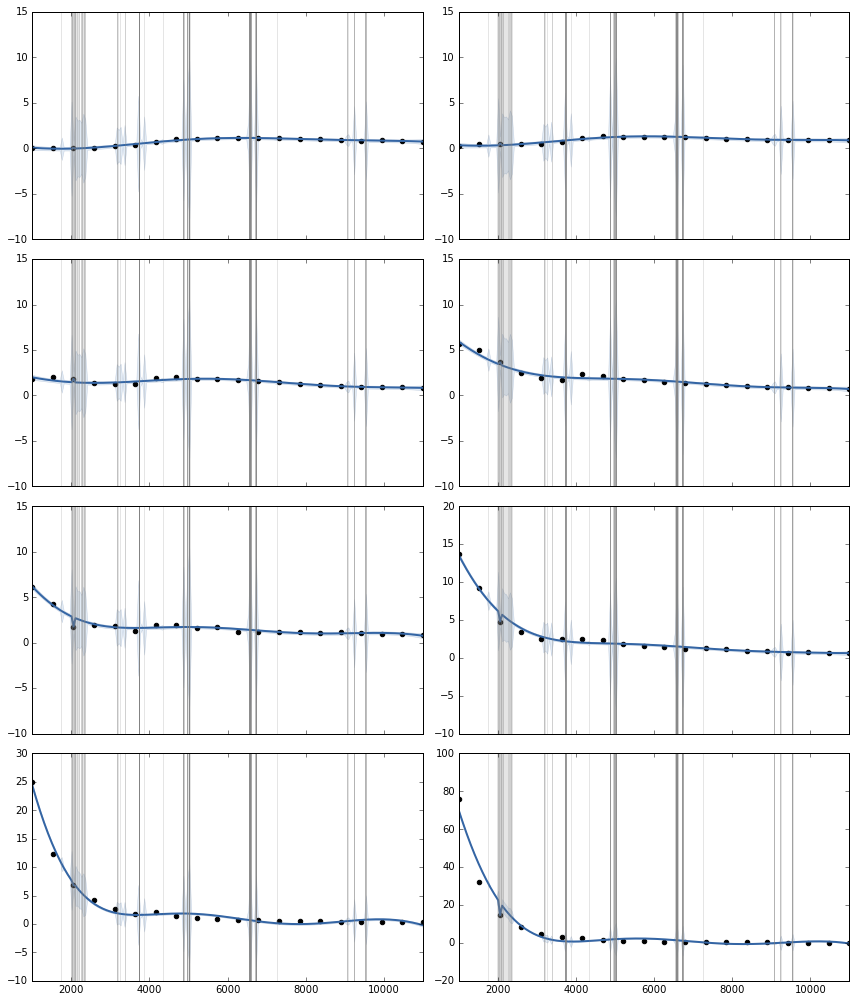

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(12, 14), sharex=True, sharey=False)
axs = axs.ravel()
xlamb = np.linspace(lambdaMinAbs, lambdaMaxAbs, num=1000)
for t in range(8):
    ind = np.where(X_nolines[:,0].astype(int) == t)[0]
    m_rbf_nolines.plot_f(fixed_inputs=[(0,t)], ax=axs[t], legend=False, resolution=200, samples=0,
            plot_limits=[lambdaMinAbs, lambdaMaxAbs], 
                  plot_data=False, plot_inducing=False, plot_density=False, 
                  lower=16, upper=84)#, lower=2.5, upper=97.5)
    axs[t].scatter(X_nolines[ind,1], Y_nolines[ind], color='k') 
    for mu, sig in zip(m_rbf.kern.lines_mu, m_rbf.kern.lines_sig):
        axs[t].axvline(mu, color='gray', alpha=0.2)
        #axs[t].axvspan(mu-2*sig, mu+2*sig, color='gray', alpha=0.5)
fig.tight_layout()

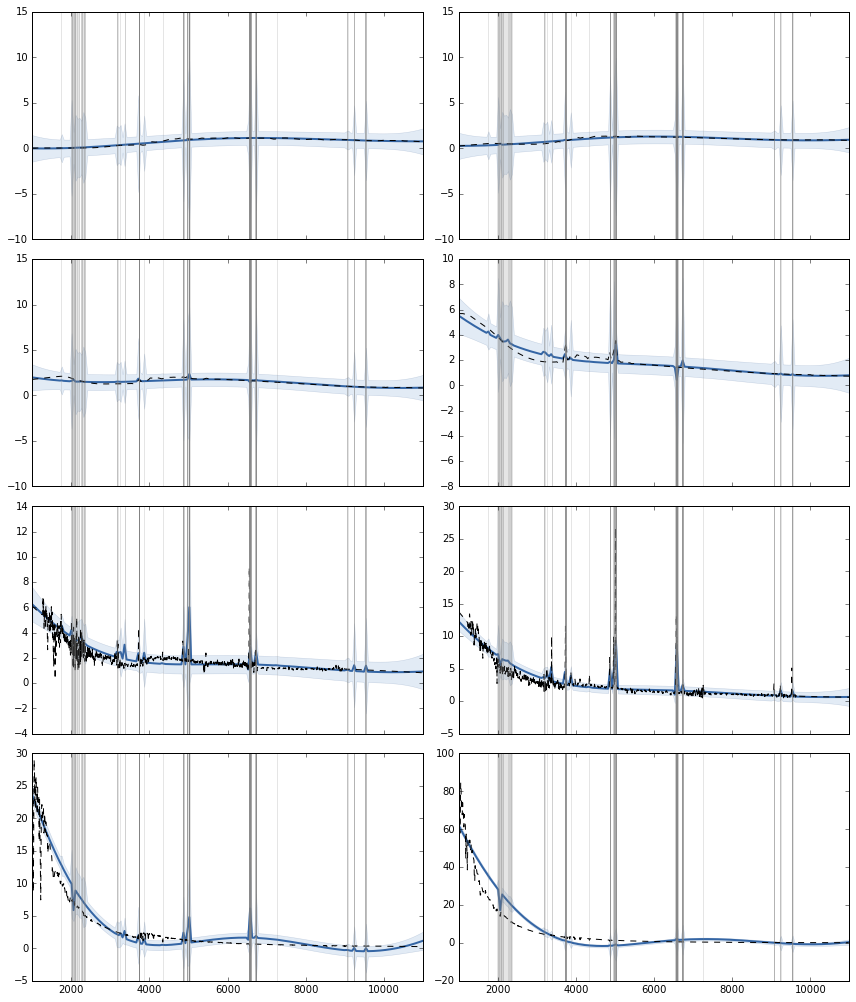

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(12, 14), sharex=True, sharey=False)
axs = axs.ravel()
xlamb = np.linspace(lambdaMinAbs, lambdaMaxAbs, num=1000)
for t in range(8):
    ind = np.where(X[:,0].astype(int) == t)[0]
    #axs[t].plot(xlamb, sed_interp[t](xlamb), color='k')
    m_rbf.plot_f(fixed_inputs=[(0,t)], ax=axs[t], legend=False, resolution=200, samples=0,
            plot_limits=[lambdaMinAbs, lambdaMaxAbs], 
                  plot_data=False, plot_inducing=False, plot_density=False, 
                  lower=16, upper=84)#, lower=2.5, upper=97.5)
    #axs[t].scatter(X[ind,1], Y[ind], color='k') 
    data = np.genfromtxt('/Users/bl/Dropbox/software/bpz-1.99.3/SED/'+template_names[t]+'.sed')
    ind = np.logical_and(data[:,0] >= lambdaMinAbs, data[:,0] <= lambdaMaxAbs)
    axs[t].plot(data[ind,0], data[ind,1], color='k', ls='dashed') 
    for mu, sig in zip(m_rbf.kern.lines_mu, m_rbf.kern.lines_sig):
        axs[t].axvline(mu, color='gray', alpha=0.2)
        #axs[t].axvspan(mu-2*sig, mu+2*sig, color='gray', alpha=0.5)
fig.tight_layout()

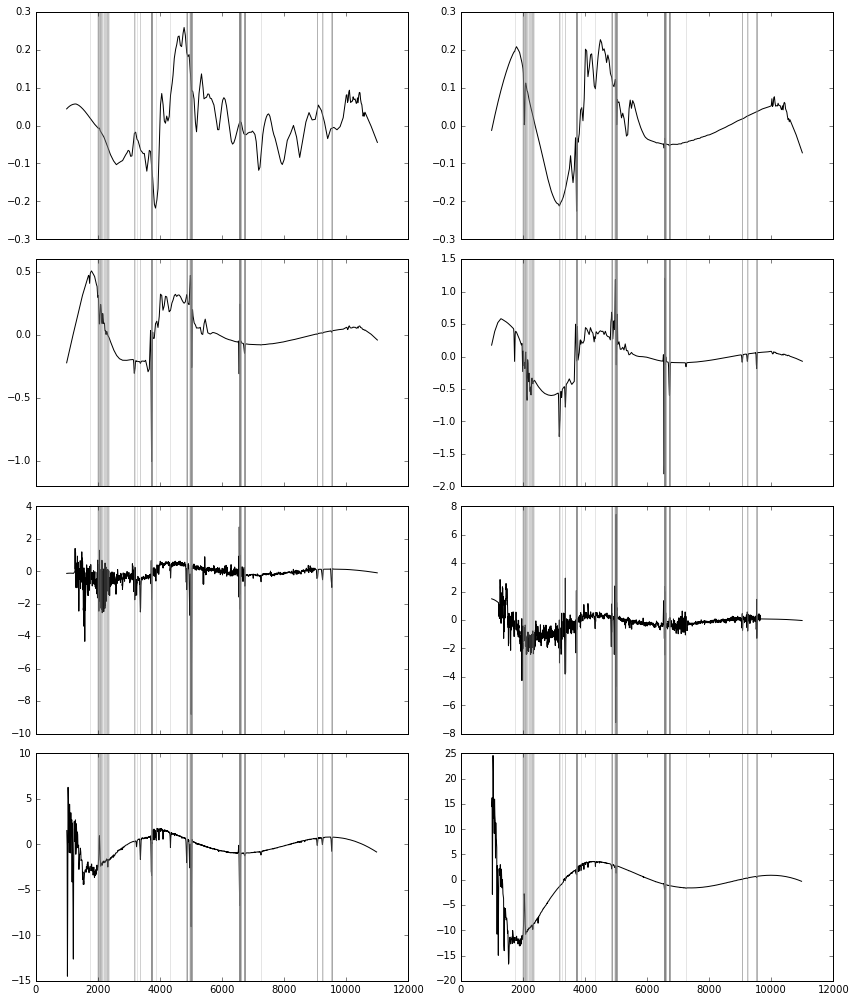

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(12, 14), sharex=True, sharey=False)
axs = axs.ravel()
xlamb = np.linspace(lambdaMinAbs, lambdaMaxAbs, num=1000)
for t in range(8):
    data = np.genfromtxt('/Users/bl/Dropbox/software/bpz-1.99.3/SED/'+template_names[t]+'.sed')
    ind = np.logical_and(data[:,0] >= lambdaMinAbs, data[:,0] <= lambdaMaxAbs)
    Xb = np.vstack((0*data[ind,0]+t, data[ind,0])).T
    mu, C = m_rbf.predict(Xb[:,:], full_cov=False)
    axs[t].plot(data[ind,0], data[ind,1] - mu.flatten(), color='k') 
    for mu, sig in zip(m_rbf.kern.lines_mu, m_rbf.kern.lines_sig):
        axs[t].axvline(mu, color='gray', alpha=0.2)
        #axs[t].axvspan(mu-2*sig, mu+2*sig, color='gray', alpha=0.5)
fig.tight_layout()

In [163]:
num = 6
numpoints = num*nt
#redshifts = np.random.uniform(low=0, high=max_redshift, size=numpoints)
redshifts = np.outer(np.linspace(0, max_redshift, num=num), np.ones(nt)).T.flatten()
#types = np.random.randint(low=0, high=nt, size=numpoints)
types = np.outer(np.ones(num), np.arange(nt)).T.flatten()
#redshifts[:] = 0.5
nd = nf*numpoints
X = np.zeros((nd, 3))
Ytruth = np.zeros((nd, ))
Ynoise = np.zeros((nd, ))
Y = np.zeros((nd, ))
off = 0
Ynoisevarianceval = 0.01
for ip in range(numpoints):
    for jf in range(nf):
        X[off, 0] = types[ip]
        X[off, 1] = jf
        X[off, 2] = redshifts[ip]
        Ytruth[off] = f_mod_interps[types[ip], jf](redshifts[ip])
        Ynoise[off] = Ynoisevarianceval
        Y[off] = Ytruth[off] + Ynoise[off] * np.random.randn()
        off += 1

 /Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning:using a non-integer number instead of an integer will result in an error in the future


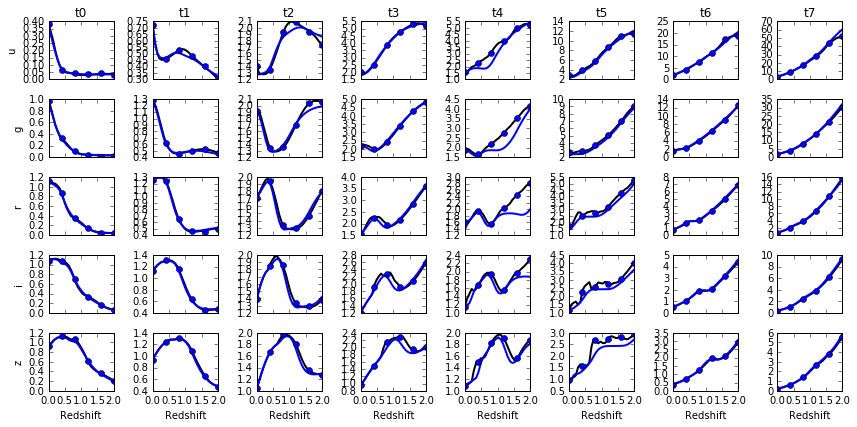

In [164]:
fig, axs = plt.subplots(5, len(template_names), figsize=(12, 6), sharex=True, sharey=False)
for bi in range(numBands):
    for t in range(len(template_names)):
        #axs[bi,t].plot(redshiftGrid, -2.5*np.log10(f_mod[:,t,bi+1]/f_mod[:,t,bi]), ls='solid', lw=2)
        axs[bi,t].plot(redshiftGrid, f_mod[:,t,bi], ls='solid', c='k', lw=2)
        axs[bi,t].plot(redshiftGrid, f_mod2[:,t,bi], ls='solid', c='b', lw=2)
        ind = np.logical_and(X[:,0].astype(int) == t, X[:,1].astype(int) == bi) 
        axs[bi,t].errorbar(X[ind,2], Y[ind], yerr=Ynoise[ind], fmt='o') 
        #axs[bi,t].scatter(X[ind,2], Ytruth[ind])
        if t == 0:
            axs[bi,t].set_ylabel(ab_filters[bi])
            #axs[bi,t].set_ylabel(ab_filters[bi+1]+' - '+ab_filters[bi])
        if bi == numBands - 1:
            axs[bi,t].set_xlabel('Redshift')
        if bi == 0:
            axs[bi,t].set_title('t'+str(t)) # template_names[t])
        
fig.tight_layout()

In [198]:
lines_amp = np.array([ 5.99, 5.29, 4.02, 2.37, 2.20, 1.17, 1.13, 1.03, 1.00, 0.96, 0.89, 0.77, 0.73, -0.65, 0.60, 0.60, -0.57, 0.56, -0.51, 0.50, 0.50, 0.47, -0.47, -0.43, -0.39, 0.38, 0.38, -0.37, 0.37, -0.36, -0.35, 0.35 ])
lines_mu = np.array([ 6556.74, 9527.33, 3372.75, 9065.54, 9230.14, 7134.49, 3174.70, 7227.85, 3253.81, 6719.12, 4858.05, 3870.62, 5002.26, 1213.04, 3732.22, 6853.21, 1542.91, 4343.24, 1392.07, 2009.82, 3528.47, 7027.87, 3969.87, 3835.44, 5401.32, 6292.06, 9603.17, 2795.42, 4104.03, 2384.11, 5308.43, 8775.69 ])
lines_sig = np.array([ 4.39, 5.01, 2.14, 4.99, 4.52, 3.84, 3.90, 3.13, 5.33, 10.70, 3.68, 9.18, 34.10, 8.20, 23.11, 2.49, 5.58, 8.57, 6.41, 22.81, 4.74, 11.83, 2.93, 2.46, 11.83, 3.18, 5.04, 11.14, 7.03, 2.63, 4.43, 6.77 ])

In [210]:
alpha_C = 1e3
alpha_L = 1e2
alpha_T = 0.2
V_C = 0.1
V_L = 0.1

k = Photoz(amp_arr, mu_arr, sig_arr, lines_mu, lines_sig, V_C, V_L, alpha_C, alpha_L, alpha_T)

k.change_numlines(0)

numit = 2
t1 = time()
for i in range(numit):
    a = k.K_slow(X)
    #print a
t2 = time()
for i in range(numit):
    a = k.K(X)
    #print a
t3 = time()
print (t2-t1)/numit, (t3-t2)/numit, (t2-t1)/(t3-t2)

m_full = GPy.models.GPRegression(X, Y[:,None], k)
m_full.constrain_positive('*')
m_full.kern.V_C.constrain_bounded(1e2, 1e5)
m_full.kern.V_L.fix()
m_full.kern.alpha_T.constrain_bounded(0.2, 2)
m_full.kern.alpha_C.constrain_bounded(2e3, 1e5)
m_full.kern.alpha_L.fix()
m_full.likelihood.variance.fix(Ynoisevarianceval)

0.210585474968 0.0467865467072 4.50098350464


array([0])